# Workshop: The use of Identity-By-Descent (IBD) Segments for the inference of recent demography

This notebook has been written by Océane EYCHENNE, Romain PECHEY and Pierre-Alexandre GAGNAIRE for the DevOCGen workshop.

It will guide you through three main topics of IBD segment analysis:

1. **Identification of IBD segments using simulated data**
2. **Temporal demographic inference using IBD segments**
3. **Spatial demographic inference using IBD segments**

Population genetic simulations will be used in the different sections to generate data and explore these concepts interactively.

## Setup: Activate the Required Tools

First, we need to import the simulation tools and Python packages required for running this notebook. 

The main tools we'll use are:

- **msprime**: A coalescent simulator for generating genetic variation data under the classical Wright-Fisher model
- **SLiM**: A forward-time population genetics simulator for generating genetic variation data in a spatial model (non-WF model)
- **tskit**: A library for working with tree sequence objects


Now let's import the libraries we'll need:

In [ ]:
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import pandas as pd
import random
import seaborn as sns
from IPython.display import display, HTML
from ipywidgets import widgets, interact
import itertools
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All packages imported successfully!")
print(f"msprime version: {msprime.__version__}")
print(f"tskit version: {tskit.__version__}")

---
# **Part 1: Identification of IBD Segments**

## Introduction

An **Identity By Descent (IBD) segment** refers to a continuous genomic segment that is shared identical between two individuals' chromosomes because it was inherited from a common ancestor without recombination. 
The **length of IBD segments** depends on the time to the most recent common ancestor (TMRCA): **longer IBD  segments** indicate more recent shared ancestry, whereas **shorter segments** indicate more distant ancestry (more time for recombination to break them up)

Throughout this workshop, we will use IBD segments for:

- Inferring **recent population size changes**
- Understanding **fine-scale population structure and connectivity**


## **Exercise 1.1:** Simulating a Simple Population

Let's start by simulating a simple population and recording its tree sequence (i.e. complete history of recombining genetic lineages). We'll use `msprime` to simulate genetic data under the standard coalescent.

In [ ]:
# Simulate a simple population
def simulate_simple_population(sample_size=10, Ne=1000, length=1e8, recombination_rate=1e-8, random_seed=666):
    """
    Simulate a simple population using msprime under the neutral coalescent. tree sequence with mutations.
    Returns a tskit.TreeSequence object.
    
    Parameters:
    - sample_size: number of diploid individuals to sample
    - Ne: effective population size
    - length: sequence length in base pairs
    - recombination_rate: per-base, per-generation recombination rate
    - random_seed: random seed for reproducibility
    """
    ts = msprime.sim_ancestry(
        samples=sample_size,
        population_size=Ne,
        sequence_length=length,
        recombination_rate=recombination_rate,
        random_seed=random_seed
    )
    return ts

# Run the simulation, 
ts = simulate_simple_population(sample_size=10, Ne=1000, length=1e8, recombination_rate=1e-8, random_seed=666)

print(f"Simulated tree sequence:")
print(f"  - Number of trees: {ts.num_trees}")
print(f"  - Number of samples: {ts.num_samples/2}")
print(f"  - Number of haploid copies: {ts.num_samples}")
print(f"  - Sequence length: {ts.sequence_length/1e6:.1f} Mb")
print(f"  - Number of nodes: {ts.num_nodes}")

### Visualizing the Tree Sequence

Let's visualize a portion of the tree sequence to understand its structure:

In [ ]:
# Display a subset of trees at the left end (first 25kb) of the chromosome:
subset_ts = ts.keep_intervals([[0, 25000]], simplify=True)
subset_ts.draw_svg(y_axis=True, size=(2000, 400))

In [ ]:
# --- Question 1: MRCA node ---
question_text = "What is the MRCA node to sample leaves 0 and 1 in the first tree?"

# --- Input widget ---
answer_input = widgets.Text(
    description='Answer:',
    placeholder='Enter node number'
)

# --- Output widget ---
output = widgets.Output()

# --- Check function ---
def check_answer(change):
    with output:
        output.clear_output()
        if change['new'].strip() == "39":
            display(HTML("<span style='color:green;'>correct!</span>"))
        else:
            display(HTML("<span style='color:red;'>The MRCA node to sample leaves 0 and 1 in the first tree is 39.</span>"))

# --- Link input to check ---
answer_input.observe(check_answer, names='value')

# --- Display question and widgets ---
display(HTML(f"<b>{question_text}</b>"))
display(answer_input, output)

In [ ]:
# --- Question 2: MRCA node ---
question_text = "What is the MRCA node to sample leaves 0 and 1 in the second tree?"

# --- Input widget ---
answer_input = widgets.Text(
    description='Answer:',
    placeholder='Enter node number'
)

# --- Output widget ---
output = widgets.Output()

# --- Check function ---
def check_answer(change):
    with output:
        output.clear_output()
        if change['new'].strip() == "38":
            display(HTML("<span style='color:green;'>correct!</span>"))
        else:
            display(HTML("<span style='color:red;'>The MRCA node to sample leaves 0 and 1 in the first tree is 38.</span>"))

# --- Link input to check ---
answer_input.observe(check_answer, names='value')

# --- Display question and widgets ---
display(HTML(f"<b>{question_text}</b>"))
display(answer_input, output)

In [ ]:
# --- Question 3: IBD segment ---
question_text = "What is the length of the first IBD segment shared between sample leaves 0 and 1 (in bp)?"

# --- Input widget ---
answer_input = widgets.Text(
    description='Answer:',
    placeholder='Enter IBD segment length'
)

# --- Output widget ---
output = widgets.Output()

# --- Check function ---
def check_answer(change):
    with output:
        output.clear_output()
        if change['new'].strip() == "1722":
            display(HTML("<span style='color:green;'>correct!</span>"))
        else:
            display(HTML("<span style='color:red;'>The length of the first IBD segment shared between sample leaves 0 and 1 is 1722 bp.</span>"))

# --- Link input to check ---
answer_input.observe(check_answer, names='value')

# --- Display question and widgets ---
display(HTML(f"<b>{question_text}</b>"))
display(answer_input, output)

In [ ]:
# --- Question 4: IBD segment ---
question_text = "What is the length of the first IBD segment shared between sample leaves 0 and 2 (in bp)?"

# --- Input widget ---
answer_input = widgets.Text(
    description='Answer:',
    placeholder='Enter IBD segment length'
)

# --- Output widget ---
output = widgets.Output()

# --- Check function ---
def check_answer(change):
    with output:
        output.clear_output()
        if change['new'].strip() == "25000":
            display(HTML("<span style='color:green;'>correct!</span>"))
        else:
            display(HTML("<span style='color:red;'>The length of the first IBD segment shared between sample leaves 0 and 2 is 25000 bp.</span>"))

# --- Link input to check ---
answer_input.observe(check_answer, names='value')

# --- Display question and widgets ---
display(HTML(f"<b>{question_text}</b>"))
display(answer_input, output)

## **Exercise 1.2:** Computing IBD Segments

Now, let's identify IBD segments between pairs of individuals automatically.
We start by defining a new function to **perform IBD segment detection** directly from the tree sequence, to find **continuous regions where samples share recent common ancestry**.

In [ ]:
#################### The Extract_stitched_IBD_segments function ####################

### Contributors:
#####    - Iago BONNICI <iago.bonnici@umontpellier.fr> ( Research engineer at the Montpellier Bioinformatics Biodiversity platform (MBB))
#####    - Océane EYCHENNE <oceane.eychenne@cefe.cnrs.fr> ( PhD student at the Center for Functional and Evolutionary Ecology (CEFE) and Institute for Evolutionary Sciences of Montpellier (ISEM)) 
#####    - Romain PECHEY <romain.pechey@umontpellier.fr> ( PhD student at the Institute for Evolutionary Sciences of Montpellier (ISEM) and Marine Biodiversity Exploitation and Conservation (MARBEC))
### This snippet is distibuted under the same license terms as tskit: https://github.com/tskit-dev/tskit.
# Date: 16/04/2025
# See details on the rationale at: https://github.com/tskit-dev/tskit/discussions/3142.

def Extract_stitched_IBD_segments(ts, min_span=0, max_time=None):
    """
    Extract stitched IBD segments between pairs of haplotypes from a .trees file
    
    Parameters:
    - ts: a tree sequence file
    - min_span: minimum length (in bp) of extracted IBD segments
    - max_time: maximum age (in generations) of extracted IBD segments
    
    Returns:
    - DataFrame with IBD segments (Haplotype Pair, Left Coordinate, Right Coordinate, Length in bp, Node, Time to MRCA)
    """

    # Extract full list of unstitched IBD segments using the tskit ibd_segments() function:
    segments = ts.ibd_segments(store_pairs=True, store_segments=True, min_span=0, max_time=max_time)

    # Initialize empty vectors to store stitch IBD informations:
    Pair = []
    Left = np.array([])
    Right = np.array([])
    Node = np.array([])
    Time = np.array([])

    # For each pair of individuals, extract the start and end positions of segments and the node ID of the MRCA.
    # Sort these values to align them along the sequence.
    for k, v in segments.items():
        kLeft = v.left
        kRight = v.right
        kNode = v.node

        order = kLeft.argsort()
        l = kLeft[order]
        n = kNode[order]
        r = kRight[order]

        # Use convolution and concatenation to merge adjacent segments with the same MRCA
        node = (np.convolve(n + (n[0] == 0), [-1, 1]) != 0)[:-1]
        discontinuities = np.concatenate(([True], l[1:] != r[:-1]))
        i = np.where(node | discontinuities)[0]

        # Recalculate left and right coordinates of IBD segments after stitching
        kPair = [k] * len(i)
        kLeft = l[i]
        kRight = np.append(r[i[1:] - 1], r[-1])
        kNode = n[i]

        # Store the values into previously defined vectors
        Pair += kPair
        Left = np.append(Left, kLeft)
        Right = np.append(Right, kRight)
        Node = np.append(Node, kNode)
        Time = np.append(Time, ts.tables.nodes.time[kNode])

    # Compute segment lengths
    Length = Right - Left

    # Create a dataframe with stitch IBD segments information:
    ibd_segments = pd.DataFrame(columns=['Pair', 'Left', 'Right', 'Length', 'Node', 'Time'])
    ibd_segments['Pair'] = Pair
    ibd_segments['Left'] = Left
    ibd_segments['Right'] = Right
    ibd_segments['Length'] = Length
    ibd_segments['Node'] = Node
    ibd_segments['Time'] = Time
    
    return pd.DataFrame(ibd_segments)


**Apply the Extract_stitched_IBD_segments function** on the previously stored subset of trees to find IBD segments:

In [ ]:
ibd_df = Extract_stitched_IBD_segments(subset_ts, min_span=0, max_time=None)

print(f"Found {len(ibd_df)} IBD segments")
print("\nFirst few IBD segments:")
display(ibd_df.head(10))

Now lets **extract IBD segments for the complete tree sequence** (i.e. chromosome-wide):

In [ ]:
ibd_df_full = Extract_stitched_IBD_segments(ts, min_span=0, max_time=None)

print(f"Found {len(ibd_df_full)} IBD segments")
print("\nFirst few IBD segments:")
display(ibd_df_full.head(10))

### Visualizing IBD Segment Distributions

In [ ]:
fig, plot = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: IBD length distribution
plot[0].hist(ibd_df_full['Length']/1e6, bins=100, edgecolor='black', alpha=0.7)
plot[0].set_yscale('log')
plot[0].set_xlabel('IBD Segment Length (Mb)')
plot[0].set_ylabel('Number of IBD segments')
plot[0].set_title('Length distribution of IBD Segments')

# Plot 2: TMRCA vs length
plot[1].scatter(ibd_df_full['Time'], ibd_df_full['Length']/1e6, alpha=0.5)
plot[1].set_xlabel('TMRCA (generations)')
plot[1].set_ylabel('IBD Segment Length (Mb)')
plot[1].set_title('IBD segments Length as a function of Time to MRCA')

plt.tight_layout()
plt.show()

In [ ]:
# --- Question 5: IBD segment length vs TMRCA ---
question_text = "What is the relationship between IBD segment length and TMRCA?"

# --- Options ---
options = [
    'Select...',  # placeholder
    'Longer segments indicate more ancient ancestry',
    'Longer segments indicate more recent ancestry',
    'There is no relationship between length and TMRCA',
    'Segment length depends only on population size'
]

# --- Radio buttons ---
answer_input = widgets.RadioButtons(
    options=options,
    description='Answer:',
    disabled=False,
    layout=widgets.Layout(width='600px')  # wide container
)

# --- Output widget ---
output = widgets.Output()

# --- Check function ---
def check_answer(change):
    with output:
        output.clear_output()
        if answer_input.value == '':
            # Do nothing if user hasn't picked anything
            return
        elif answer_input.value == 'Longer segments indicate more recent ancestry':
            display(HTML("<span style='color:green;'>✓ Correct! Longer IBD segments indicate more recent common ancestry because there has been less time for recombination to break them up.</span>"))
        else:
            display(HTML("<span style='color:red;'>✗ Not quite. Think about what happens to IBD segments over time due to recombination.</span>"))

answer_input.observe(check_answer, names='value')

# --- Display ---
display(HTML(f"<b>{question_text}</b>"))
display(answer_input, output)

## **Exercise 1.3:** Effect of Recombination Rate

Let's explore how recombination rate affects the number and length of IBD segments.

In [ ]:
# Simulate with different recombination rates
recomb_rates = [1e-9, 1e-8, 1e-7]
results = []

for rate in recomb_rates:
    ts_temp = simulate_simple_population(sample_size=10, Ne=1000, length=1e8, 
                                         recombination_rate=rate, random_seed=666)
    ibd_temp = Extract_stitched_IBD_segments(ts_temp, min_span=0, max_time=None)
    results.append({
        'rate': rate,
        'num_segments': len(ibd_temp),
        'mean_length': ibd_temp['Length'].mean() if len(ibd_temp) > 0 else 0,
        'num_trees': ts_temp.num_trees
    })

results_df = pd.DataFrame(results)
print("Effect of recombination rate:")
display(results_df)


In [ ]:
# Visualize the effect of recombination rate
fig, plot = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: 
plot[0].plot(results_df['rate'], results_df['num_segments'], marker='o', linewidth=2)
plot[0].set_xscale('log')
plot[0].set_yscale('log')
plot[0].set_xlabel('Recombination Rate (per bp per generation)')
plot[0].set_ylabel('Number of IBD Segments')
plot[0].set_title('IBD Segments vs. Recombination Rate')

# Plot 2: 
plot[1].plot(results_df['rate'], results_df['mean_length'], marker='o', linewidth=2, color='orange')
plot[1].set_xscale('log')
plot[1].set_yscale('log')
plot[1].set_xlabel('Recombination Rate (per bp per generation)')
plot[1].set_ylabel('Mean IBD Length (bp)')
plot[1].set_title('Mean IBD Length vs. Recombination Rate')

plt.tight_layout()
plt.show()

In [ ]:
# --- Question 6: IBD segment length vs Recombination ---
question_text = "How does recombination rate affect IBD segment detection?"

# --- Options (with empty placeholder so nothing is selected by default) ---
options = [
    'Select...',  # placeholder
    'Higher recombination leads to fewer, longer IBD segments',
    'Higher recombination leads to more, shorter IBD segments',
    'Recombination has no effect on IBD segments',
    'Higher recombination eliminates all IBD segments'
]

# --- Radio buttons ---
answer_input = widgets.RadioButtons(
    options=options,
    description='Answer:',
    disabled=False,
    layout=widgets.Layout(width='700px')  # wider so long options fit
)

# --- Output widget ---
output = widgets.Output()

# --- Check function ---
def check_answer(change):
    with output:
        output.clear_output()
        if answer_input.value == 'Select...':
            return  # Do nothing until user picks a real option
        elif answer_input.value == 'Higher recombination leads to more, shorter IBD segments':
            display(HTML("<span style='color:green;'>✓ Correct! Higher recombination breaks up ancestral segments more frequently, resulting in more numerous but shorter IBD segments.</span>"))
        else:
            display(HTML("<span style='color:red;'>✗ Not quite. Think about how recombination breaks up chromosomal segments.</span>"))

# --- Link radio buttons to check function ---
answer_input.observe(check_answer, names='value')

# --- Display question and widgets ---
display(HTML(f"<b>{question_text}</b>"))
display(answer_input, output)

## **Exercise 1.4:** Comparing Simulated and Theoretical IBD Length Distributions

The **distribution of IBD segment lengths** contains important information about demography. 

According to **Palamara et al. (2012)**, the expected length distribution of IBD segments can be derived analytically using the distribution of TMCRA (which depends only on demography) and the distribution of recombination distances. 
Therefore, **demography and recombination can be treated separately**.

### Theoretical Background from Palamara et al. 2012:
For a pair of haplotypes that coalesce at time $t$ generations ago, the length of the resulting shared IBD segment is **only dependent on the number of generations** separating the pair of haplotypes, which is equal to $2t$ generations.

The distribution of the distance to the first recombination event encountered as we move either upstream or downstream of a chosen genomic site is exponentially distributed (with a mean of $t$=50cM). This is because with TMRCA of $t$ generations and recombination rate of 1 per Morgan per generation, we expect $2t$ recombination events per Morgan on each side of the segment. 
The total length of the shared segment is therefore distributed as the sum of two independent exponential random variables of mean $t$=50cM (i.e. the Erlang-2 distribution).

Let's compare this theoretical expectation with IBD segments obtained by simulation.

In [ ]:
# --- Set up new simulation parameters ---
Ne_test = 1000         # effective population size of 1000
SS_test = 50           # sample size of 50 diploid individuals
recomb_rate = 1e-8     # recombination rate (1 cM per Mb)
sequence_length = 1e8  # one chromosome of 100 Mb
bin_size_pb = 1e6      # 1 Mb-sized bins length intervals
seed = 666             # set seed for reproducibility

# Let's re-simulate with the newly defined set of parameters, using constant effective population size:
ts_test = simulate_simple_population(sample_size=SS_test, Ne=Ne_test, length=sequence_length, recombination_rate=recomb_rate, random_seed=seed)

# Extract IBD segments:
ibd_test = Extract_stitched_IBD_segments(ts_test, min_span=0, max_time=None)

print(f"Found {len(ibd_test)} IBD segments for comparison")
print(f"Mean TMRCA: {ibd_test['Time'].mean():.1f} generations")
print(f"Mean length: {ibd_test['Length'].mean()/1e6:.2f} Mb")

# Plot the simulated IBD segments' length distribution:
res = plt.hist(ibd_test["Length"]/1e6, bins=100, color='thistle', edgecolor='white')
title = 'Length distribution of simulated IBD segments'
plt.xlabel('Length (Mb)')
plt.ylabel('Number')
plt.title(title)
plt.yscale('log')
plt.show()


Now, we implement **Equation 3 from Palamara et al. 2012** to obtain the **predicted length distribution of IBD segments**.

In [ ]:
# Bin IBD lengths from the dataframe containing extracted IBD segments: 
ibd_test["Length_cM"] = ibd_test["Length"] * 1e-6  
counts, bin_edges = np.histogram(ibd_test["Length_cM"], bins=100, range=(0, 100), density=False)

# Count the number of meioses (i.e. generations) separating pairs of individuals at each segment:
meiosis_distances = ibd_test['Time'] * 2
# Count the number of segments for each number of meioses
meiosis_distances = [int(round(d)) for d in meiosis_distances if d > 0]
meiosis_counts = Counter(meiosis_distances)

# Account for recombination at each meiosis using Erlang2 law to compute the expected number of IBD segments per bin:
def expected_ibd_segments_per_bin(meiosis_counts, genome_length, bin_size_pb, recomb_rate_per_bp):
    # Total number of IBD segments to predict
    total_pairs = sum(meiosis_counts.values())
    
    # Prepare intervals for binning IBD segments
    bins_start = np.arange(0, genome_length, bin_size_pb)
    bins_end = bins_start + bin_size_pb
    
    # Convert intervals coordinates in centiMorgans
    recomb_rate_in_cM_per_mb = recomb_rate_per_bp * 1e6 * 1e2
    bins_start_cM = (bins_start / 1e6) * recomb_rate_in_cM_per_mb
    bins_end_cM = (bins_end / 1e6) * recomb_rate_in_cM_per_mb

    total_ibd_by_bin = []
    # For each bin defining a length range R=[u,v], we predict the number of IBD segments whose length lies within that interval
    for i, (u, v) in enumerate(zip(bins_start_cM, bins_end_cM)):
        total_ibd = 0.0
        # For m meioses found in count IBD segments
        for m, count in meiosis_counts.items():
            # Calculate the probability of finding an IBD segment whose length lies within interval [u,v]
            segment_prob = (m / 100) * (np.exp(-m * u / 100) - np.exp(-m * v / 100)) 
            # Transform into predicted count
            total_ibd += segment_prob * count
        total_ibd_by_bin.append(total_ibd)

    ibd_count_raw = np.array(total_ibd_by_bin)
    
    return ibd_count_raw, bins_start, bins_end

# Calculate the distribution of raw ibd counts per bin 
ibd_count_raw, bins_start, bins_end = expected_ibd_segments_per_bin(meiosis_counts, sequence_length, bin_size_pb, recomb_rate)

# Define bounds u and v
recomb_rate_in_cM_per_mb = recomb_rate * 1e6 * 1e2
bins_start_cM = (bins_start / 1e6) * recomb_rate_in_cM_per_mb
bins_end_cM = (bins_end / 1e6) * recomb_rate_in_cM_per_mb

bin_widths_cM = bins_end_cM - bins_start_cM
bin_centers_cM = (bins_start + bins_end) / 2 * recomb_rate * 100

plt.figure(figsize=(8, 5))
plt.bar(bins_start * recomb_rate * 100, counts,
        width=bin_widths_cM, align='edge', color='pink', label='IBD from simulated data')
plt.plot(bin_centers_cM, ibd_count_raw, marker='+', linestyle='none', color='purple', label='Theoretical prediction', markersize=6)
plt.yscale('log')
plt.xlabel("IBD segemnts length (cM)")
plt.ylabel("Nulmber of IBD segments")
plt.title("Comparison of simulated vs theoretical length distributions of IBD segments")
plt.legend()
plt.tight_layout()
plt.show()


---
# **Part 2: Temporal Demographic Inference**

## Introduction

IBD segments can be used to infer **effective population size history over time**. The distribution of IBD segment lengths contains information about population size changes (expansions, bottlenecks) in the **recent history** (last ~100-200 generations).

### Key Principle:

The rate of IBD sharing at different time depths reflects the effective population size at those times:
- **More IBD sharing** → smaller effective population size
- **Less IBD sharing** → larger effective population size

## **Exercise 2.1:** Simulating Population Size Changes

Let's simulate populations with different demographic histories and see how they affect IBD patterns.

In [ ]:
def simulate_bottleneck(sample_size=50, bottleneck_time=200, bottleneck_Ne=1000, 
                       ancient_Ne=10000, length=1e7, random_seed=666):
    """
    Simulate a population that experienced a recent bottleneck.
    """
    # Define demographic events
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=bottleneck_Ne)
    demography.add_population_parameters_change(time=bottleneck_time, population="A", initial_size=ancient_Ne)
    
    ts = msprime.sim_ancestry(
        samples={"A": sample_size},
        demography=demography,
        sequence_length=length,
        recombination_rate=1e-8,
        random_seed=random_seed
    )
    return ts

def simulate_expansion(sample_size=50, expansion_time=200, ancient_Ne=1000,
                      modern_Ne=10000, length=1e7, random_seed=666):
    """
    Simulate a population that experienced a rencent expansion.
    """
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=modern_Ne)
    demography.add_population_parameters_change(time=expansion_time, population="A", initial_size=ancient_Ne)
    
    ts = msprime.sim_ancestry(
        samples={"A": sample_size},
        demography=demography,
        sequence_length=length,
        recombination_rate=1e-8,
        random_seed=random_seed
    )
    return ts

# Simulate different scenarios
ts_constant = simulate_simple_population(sample_size=50, Ne=10000, length=1e7, random_seed=666)
ts_bottleneck = simulate_bottleneck(sample_size=50, random_seed=666)
ts_expansion = simulate_expansion(sample_size=50, random_seed=666)

print("Simulations completed!")
print(f"Constant size: {ts_constant.num_trees} trees")
print(f"Bottleneck: {ts_bottleneck.num_trees} trees")
print(f"Expansion: {ts_expansion.num_trees} trees")

## **Exercise 2.2:** Comparing IBD Patterns Across Demographic Scenarios

In [ ]:
# Find IBD segments for each scenario
ibd_constant = Extract_stitched_IBD_segments(ts_constant, min_span=0, max_time=2000)
ibd_bottleneck = Extract_stitched_IBD_segments(ts_bottleneck, min_span=0, max_time=2000)
ibd_expansion = Extract_stitched_IBD_segments(ts_expansion, min_span=0, max_time=2000)

# Add scenario labels
ibd_constant['scenario'] = 'Constant'
ibd_bottleneck['scenario'] = 'Bottleneck'
ibd_expansion['scenario'] = 'Expansion'

# Combine data
ibd_all = pd.concat([ibd_constant, ibd_bottleneck, ibd_expansion])

print(f"IBD segments found:")
print(f"  Constant: {len(ibd_constant)}")
print(f"  Bottleneck: {len(ibd_bottleneck)}")
print(f"  Expansion: {len(ibd_expansion)}")

In [ ]:
# Visualize IBD distributions
fig, plot = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Length distributions of IBD segments
for scenario in ['Constant', 'Bottleneck', 'Expansion']:
    data = ibd_all[ibd_all['scenario'] == scenario]['Length']/1e6
    plot[0, 0].hist(data, bins=50, range=(0, 10), alpha=0.5, label=scenario)
    plot[0, 0].set_yscale('log')
    plot[0, 0].set_xlabel('IBD Segment Length (Mb)')
    plot[0, 0].set_ylabel('Number of IBD segments')
    plot[0, 0].set_title('IBD Length Distribution')
    plot[0, 0].legend()

# Plot 2: TMRCA distributions
for scenario in ['Constant', 'Bottleneck', 'Expansion']:
    data = ibd_all[ibd_all['scenario'] == scenario]['Time']
    plot[0, 1].hist(data, bins=50, range=(0, 2000), alpha=0.5, label=scenario)
    plot[0, 1].set_xlabel('TMRCA (generations)')
    plot[0, 1].set_ylabel('Number of IBD segments')
    plot[0, 1].set_title('TMRCA Distribution')
    plot[0, 1].legend()

# Plot 3: Length vs TMRCA (Bottleneck)
plot[1, 0].scatter(ibd_bottleneck['Time'], ibd_bottleneck['Length']/1e6, alpha=0.3, color='orange')
plot[1, 0].set_xlim(-10, 1000)
plot[1, 0].set_xlabel('TMRCA (generations)')
plot[1, 0].set_ylabel('IBD Length (Mb)')
plot[1, 0].set_title('Bottleneck Population')

# Plot 4: Length vs TMRCA (Expansion)
plot[1, 1].scatter(ibd_expansion['Time'], ibd_expansion['Length']/1e6, alpha=0.3, color='green')
plot[1, 1].set_xlim(-10, 1000)
plot[1, 1].set_xlabel('TMRCA (generations)')
plot[1, 1].set_ylabel('IBD Length (Mb)')
plot[1, 1].set_title('Expansion Population')

plt.tight_layout()
plt.show()

In [ ]:
# --- Question 7: IBD in a bottlenecked population ---
question_text = "What would you expect to see in the IBD data of a population that experienced a recent bottleneck?"

# --- Options (with placeholder so nothing is selected initially) ---
options = [
    'Select...',  # placeholder
    'Fewer IBD segments overall',
    'More long IBD segments',
    'Only very short IBD segments',
    'No change in IBD patterns'
]

# --- Radio buttons ---
answer_input = widgets.RadioButtons(
    options=options,
    description='Answer:',
    disabled=False,
    layout=widgets.Layout(width='700px')  # wide so text fits nicely
)

# --- Output widget ---
output = widgets.Output()

# --- Check function ---
def check_answer(change):
    with output:
        output.clear_output()
        if answer_input.value == 'Select...':
            return  # Don't show feedback until a real option is chosen
        
        if answer_input.value == 'More long IBD segments':
            display(HTML(
                "<span style='color:green;'>✓ Correct! A bottleneck reduces diversity and causes individuals to share more "
                "recent common ancestors, leading to more and longer IBD segments.</span>"
            ))
        else:
            display(HTML(
                "<span style='color:red;'>✗ Not quite. Think about what happens to genetic diversity during a bottleneck.</span>"
            ))

# --- Attach event ---
answer_input.observe(check_answer, names='value')

# --- Display question and widgets ---
display(HTML(f"<b>{question_text}</b>"))
display(answer_input, output)

## **Exercise 2.3:** Inferring Population Size from IBD

We can estimate effective population size over time using the distribution of IBD segment lengths.

In [ ]:
def estimate_Ne_from_ibd(ibd_df, time_bins, sequence_length):
    """
    Estimate effective population size temporal trends from IBD segments.
    
    Parameters:
    - ibd_df: DataFrame with IBD segments
    - time_bins: time bins for estimation
    - sequence_length: total sequence length
    """
    ne_estimates = []
    
    for i in range(len(time_bins)-1):
        t_start = time_bins[i]
        t_end = time_bins[i+1]
        
        # Count IBD segments in this time range
        mask = (ibd_df['Time'] >= t_start) & (ibd_df['Time'] < t_end)
        n_segments = mask.sum()
        
        if n_segments > 0:
            # Total IBD length in this bin
            total_length = ibd_df[mask]['Length'].sum()
            
            # Estimate Ne (simplified, inversely proportional to IBD sharing)
            ne_est = sequence_length / (total_length + 1) * 200000  # scaling factor
            
            ne_estimates.append({
                'time_midpoint': (t_start + t_end) / 2,
                'Ne': ne_est,
                'n_segments': n_segments
            })
    
    return pd.DataFrame(ne_estimates)

# Define time bins
time_bins = np.linspace(0, 2000, 21)

# Estimate Ne for each scenario
ne_constant = estimate_Ne_from_ibd(ibd_constant, time_bins, ts_constant.sequence_length)
ne_bottleneck = estimate_Ne_from_ibd(ibd_bottleneck, time_bins, ts_bottleneck.sequence_length)
ne_expansion = estimate_Ne_from_ibd(ibd_expansion, time_bins, ts_expansion.sequence_length)

# Plot Ne estimates
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(ne_constant['time_midpoint'], ne_constant['Ne'], 'o-', label='Constant', linewidth=2)
ax.plot(ne_bottleneck['time_midpoint'], ne_bottleneck['Ne'], 's-', label='Bottleneck', linewidth=2)
ax.plot(ne_expansion['time_midpoint'], ne_expansion['Ne'], 'p-', label='Expansion', linewidth=2)

# Add true values
ax.axhline(y=10000, color='blue', linestyle=':', alpha=0.5, label='True Ne (constant)')
# Epoch 1: from t = 0 to t = 200 generations
ax.hlines(y=1000, xmin=0, xmax=200, color='orange', linestyle='-.', alpha=0.5, label='True Ne (bottleneck)')
ax.hlines(y=10000, xmin=0, xmax=200,  color='green', linestyle='--', alpha=0.5, label='True Ne (expansion)')
# Size change
ax.vlines(x=200, ymin=1000, ymax=10000, color='orange', linestyle='-.', alpha=0.5, label='_nolegend_')
ax.vlines(x=200, ymin=1000, ymax=10000,  color='green', linestyle='--', alpha=0.5, label='_nolegend_')
# Epoch 2: from t = 200 to t = 2000 generations
ax.hlines(y=10000, xmin=200, xmax=2000, color='orange', linestyle='-.', alpha=0.5, label='_nolegend_')
ax.hlines(y=1000, xmin=200, xmax=2000, color='green', linestyle='--', alpha=0.5, label='_nolegend_')

ax.set_xlabel('Time (generations ago)')
ax.set_ylabel('Estimated Ne')
ax.set_title('Effective Population Size Inference from IBD')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

---
# **Part 3: Spatial Demographic Inference**

## Introduction

IBD segments can also reveal **spatial population structure** and **connectivity** during the recent history, including:

- **Migration rates** between discrete populations
- **Isolation by distance** in contiunous landscapes
- Patterns of **dispersal** and **effective density** 
- **Population splits and admixture events**

### Key Concepts:

1. **Within-population IBD sharing**: Reflects local effective population size (density)
2. **Between-population IBD sharing**: Reflects shared ancestry due to migration/dispersal
3. **IBD sharing decreases with geographic distance** (isolation by distance)

## **Exercise 3.1:** Simulating a descrete two-populations IM model

Let's simulate a population with geographic structure and migration in `msprime`.

In [ ]:
def simulate_IM_2_populations(sample_size_per_pop=10, Ne=1000, split_time=1000,
                            migration_rate=1e-4, length=1e8, random_seed=666):
    """
    Simulate Isolation-with-Migration between two populations that split in the past with ongoing migration.
    """
    demography = msprime.Demography()
    demography.add_population(name="Pop1", initial_size=Ne)
    demography.add_population(name="Pop2", initial_size=Ne)
    demography.add_population(name="Ancestral", initial_size=Ne)
    
    # Set migration rates
    demography.set_migration_rate(source="Pop1", dest="Pop2", rate=migration_rate)
    demography.set_migration_rate(source="Pop2", dest="Pop1", rate=migration_rate)
    
    # Population split
    demography.add_population_split(time=split_time, derived=["Pop1", "Pop2"], ancestral="Ancestral")
    
    ts = msprime.sim_ancestry(
        samples={"Pop1": sample_size_per_pop, "Pop2": sample_size_per_pop},
        demography=demography,
        sequence_length=length,
        recombination_rate=1e-8,
        random_seed=random_seed
    )
    return ts

# Simulate structured populations
ts_IM_2_pops = simulate_IM_2_populations(sample_size_per_pop=10, migration_rate=1e-4, random_seed=666)

print("Two-population Isolation-with-Migration simulation completed!")
print(f"Number of samples: {ts_IM_2_pops.num_samples}")
print(f"Number of trees: {ts_IM_2_pops.num_trees}")
print(f"Number of populations: {ts_IM_2_pops.num_populations}")

## **Exercise 3.2:** Analyzing within- vs. between-population IBD

In [ ]:
ibd_IM_2_pops = Extract_stitched_IBD_segments(ts_IM_2_pops, min_span=0, max_time=1000)

print(f"Found {len(ibd_IM_2_pops)} IBD segments")
print("\nFirst few IBD segments:")
display(ibd_IM_2_pops.head(10))

In [ ]:
def Add_ibd_segments_pair_type(ibd_df, sample_size_per_pop=10):
    """
    Classify IBD segments by population pair type, using the 'Pair' column 
    of tuples (i, j) from the IBD segments DataFrame containing
    sample_size_per_pop: number of diploid samples in each population
    Add a new column with pair type to the IBD segments DataFrame
    """

    # Compute population samples boundaries
    hap_sample_size = 2 * sample_size_per_pop  # number of haploid copies per population
    pop1_min, pop1_max = 0, hap_sample_size - 1
    pop2_min, pop2_max = hap_sample_size, 2 * hap_sample_size - 1

    def classify_pair(pair):
        i, j = pair

        # Both in Pop1
        if pop1_min <= i <= pop1_max and pop1_min <= j <= pop1_max:
            return "Within Pop1"

        # Both in Pop2
        if pop2_min <= i <= pop2_max and pop2_min <= j <= pop2_max:
            return "Within Pop2"

        # Otherwise
        return "Between Populations"

    ibd_df["Pair_Type"] = ibd_df["Pair"].apply(classify_pair)
    return ibd_df

# Find IBD segments by population
ibd_IM_2_pops_pair_types = Add_ibd_segments_pair_type(ibd_IM_2_pops, sample_size_per_pop=10)

print("IBD segments by population pair type:")
print(ibd_IM_2_pops_pair_types['Pair_Type'].value_counts())
print("\nSummary statistics:")
display(ibd_IM_2_pops_pair_types.groupby('Pair_Type')[['Length', 'Time']].describe())

In [ ]:
# Visualize within vs between population IBD
fig, plot = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Length distribution by pair type
for pair_type in ['Within Pop1', 'Within Pop2', 'Between Populations']:
    data = ibd_IM_2_pops_pair_types[ibd_IM_2_pops_pair_types['Pair_Type'] == pair_type]['Length']/1e6
    plot[0].hist(data, bins=50, range=(0, 10), alpha=0.6, label=pair_type)
    plot[0].set_yscale('log')
    plot[0].set_xlabel('IBD Length (Mb)')
    plot[0].set_ylabel('Number of IBD segements')
    plot[0].set_title('IBD Length Distribution by Population Pair')
    plot[0].legend()

# Plot 2: TMRCA distribution by pair type
for pair_type in ['Within Pop1', 'Within Pop2', 'Between Populations']:
    data = ibd_IM_2_pops_pair_types[ibd_IM_2_pops_pair_types['Pair_Type'] == pair_type]['Time']
    plot[1].hist(data, bins=50, range=(0, 1000), alpha=0.6, label=pair_type)
    plot[1].set_xlabel('TMRCA (generations)')
    plot[1].set_ylabel('Number of IBD segements')
    plot[1].set_title('TMRCA Distribution by Population Pair')
    plot[1].legend()

plt.tight_layout()
plt.show()

## **Exercise 3.3:** Effect of Migration Rate

Let's explore how migration rate affects IBD sharing between populations.

In [ ]:
# Simulate with different migration rates
migration_rates = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
migration_results = []

for mig_rate in migration_rates:
    ts_temp = simulate_IM_2_populations(sample_size_per_pop=10, Ne=1000, split_time=1000,
                            migration_rate=mig_rate, length=1e7, random_seed=666)
    ibd_temp = Extract_stitched_IBD_segments(ts_temp, min_span=0, max_time=1000)
    ibd_temp = Add_ibd_segments_pair_type(ibd_temp, sample_size_per_pop=10)
    
    # Count between-population IBD
    between_pop = ibd_temp[ibd_temp['Pair_Type'] == 'Between Populations']
    within_pop = ibd_temp[ibd_temp['Pair_Type'] != 'Between Populations']

    migration_results.append({
        'migration_rate': mig_rate,
        'between_pop_segments': len(between_pop),
        'within_pop_segments': len(within_pop),
        'ratio': len(between_pop) / len(within_pop) if len(within_pop) > 0 else 0,
        'mean_between_length': between_pop['Length'].mean() if len(between_pop) > 0 else 0
    })

migration_results_df = pd.DataFrame(migration_results)
print("Effect of migration rate on IBD sharing:")
display(migration_results_df)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(migration_results_df['migration_rate'], 
             migration_results_df['between_pop_segments'], 
             marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Migration Rate (per generation)')
axes[0].set_ylabel('Number of Between-Population IBD Segments')
axes[0].set_xscale('log')
axes[0].set_title('IBD Sharing vs. Migration Rate')
axes[0].grid(True, alpha=0.3)

axes[1].plot(migration_results_df['migration_rate'], 
             migration_results_df['ratio'], 
             marker='s', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Migration Rate (per generation)')
axes[1].set_ylabel('Between / Within IBD Ratio')
axes[1].set_xscale('log')
axes[1].set_title('Relative IBD Sharing Between Populations')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **Exercise 3.4:** Creating an IBD Sharing Matrix

A useful visualization for spatial structure is an IBD sharing matrix showing pairwise IBD between all individuals.

In [ ]:
def create_ibd_matrix(ts, ibd_df):
    """
    Create a matrix of total IBD sharing between all pairs of samples.
    """
    n_samples = ts.num_samples
    ibd_matrix = np.zeros((n_samples, n_samples))
    
    for _, row in ibd_df.iterrows():
        i, j = row['Pair']
        ibd_matrix[i, j] += row['Length']
        ibd_matrix[j, i] += row['Length']
    
    return ibd_matrix

# Create IBD matrix
ibd_matrix = create_ibd_matrix(ts_IM_2_pops, ibd_IM_2_pops)

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(ibd_matrix / 1e6, cmap='YlOrRd', aspect='auto')

# Add population boundaries
n_samples = ts_IM_2_pops.num_samples
mid_point = n_samples // 2
ax.axhline(y=mid_point-0.5, color='blue', linewidth=2, linestyle='--')
ax.axvline(x=mid_point-0.5, color='blue', linewidth=2, linestyle='--')

ax.set_xlabel('Sample ID')
ax.set_ylabel('Sample ID')
ax.set_title('Total IBD Sharing Matrix\n(Pop1: 0-19, Pop2: 20-39)')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Total IBD (Mb)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

## **Exercise 3.5:** Simulating a continuous spatial model in `SLiM`

Now let's simulate a population with geographic structure and migration in a **continuous space**.

We start by runing the spatial simulation in `SLiM` using the script `heterogeneous_N_simulations.slim` contained in the `/SLiM/` folder. The model includes parameters that determine the scale over which the following processes occur: 
- mate choice
- **offspring dispersal**
- interindividual interaction used for local **density regulation**

The simulation takes place on a spatial map where the local **carrying capacity is spatially heterogeneous**.

The figure below illustrates this heterogeneous landscape, with black areas representing regions of non-available habitat, and the local carrying capacity increasing from 0.25 to 3 individuals per pixel from gray to white pixels. 
The total map size is 100x100 pixels. 

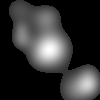

In [320]:
from IPython.display import Image
Image(filename="./SLiM/map_100x100_hetero_grayscale.png")

Because we will run `SLiM` outside of `Python`, we use the following `bash` command to start the simulation.

In [ ]:
%%bash
slim ./SLiM/heterogeneous_N_simulations.slim

Now let's process the output of the simulation:

In [ ]:
### Import the tree-sequence from the spatial SLiM simulation ###
ts_sim = tskit.load("./Tree_Sequence/forw_hetero_N_m1.0_N3.trees")
print(f"Loaded a simulated tree sequence of {ts_sim.num_samples} haploid genomes from {ts_sim.num_individuals} diploid individuals:")
print(f"containing {ts_sim.num_trees} trees over {ts_sim.sequence_length} base pairs")

### Retrieve variable values ### 
N = ts_sim.num_individuals
L = ts_sim.sequence_length
S = 100	  # Number of sampled individuals for simplify the tree sequence  

### Subsample and simplify the simulated tree sequence

# Extract the IDs of the individuals 
inds = [ind.id for ind in ts_sim.individuals()]
 
# Randomly sample S diploid individuals without replacement from the alive array
rng = np.random.default_rng()
sampled_indivs = rng.choice(inds, S, replace=False)

# Extract the nodes IDs for the sampled individuals
sampled_nodes = []
for i in sampled_indivs:
    sampled_nodes.extend(ts_sim.individual(i).nodes)
    
# Simplify the original tree sequence to retain only information about the set of sampled individuals
ts_sim_simplified = ts_sim.simplify(sampled_nodes)

print("Simplification completed!")
print(f"After subsampling {ts_sim_simplified.num_samples} haploid genomes from {ts_sim_simplified.num_individuals} diploid individuals, {ts_sim_simplified.num_trees} trees remain after simplification.")

In [ ]:
# Extract IBD segments younger than 1000 generations from the simulated tree sequence:
IBD_sim_simplified = Extract_stitched_IBD_segments(ts_sim_simplified, min_span=0, max_time=100)

print(f"Found {len(IBD_sim_simplified)} IBD segments")
print("\nFirst few IBD segments:")
display(IBD_sim_simplified.head(10))


Collect and incorporate **individuals spatial coordinates** to the IDB dataframe:

In [ ]:
### Add additonnal information on IBD dataframe
# Create new columns containing information on haplotypes IDs of each pair 
IBD_sim_simplified[['Hap1', 'Hap2']] = pd.DataFrame(IBD_sim_simplified['Pair'].tolist(), index=IBD_sim_simplified.index)  

# Create new columns containging information on individuals IDs, building a map from nodes to individuals
node_to_ind = {node_id: ts_sim_simplified.node(node_id).individual for node_id in ts_sim_simplified.samples()} 

IBD_sim_simplified["Ind1"] = IBD_sim_simplified["Hap1"].map(node_to_ind) # apply this map for recording the individual ID of the halotype1
IBD_sim_simplified["Ind2"] = IBD_sim_simplified["Hap2"].map(node_to_ind) # apply this map for recording the individual ID of the halotype2

# Return the number of IBD segments recorded 
num_ibd = len(IBD_sim_simplified.Pair) 
print(f"Recorded {num_ibd} IBD segments")
display(IBD_sim_simplified.head(60))

### Record individuals coordinates ### 
# Recover indivudals coordinates of sampled individuals
locs = []   
sampled_inds = [ind for ind in ts_sim_simplified.individuals()] # Recover information of sampled individuals
for ind in sampled_inds:                                        # Retrieve x, y coordinates of sampled individuals
    x, y = ind.location[:2]  
    locs.append((ind.id, x, y))
locs = np.array(locs)

# Save coordinates into a dataframe 												
dfLOC = pd.DataFrame(columns=['Ind', 'X', 'Y'])
sampled_inds_ids = [ind.id for ind in ts_sim_simplified.individuals()] 			
dfLOC['Ind'] = sorted(sampled_inds_ids)
dfLOC['X'] = locs[:,1] # X Coordinates 
dfLOC['Y'] = locs[:,2] # Y Coordinates 
dfLOC = dfLOC.set_index('Ind')

Num_Ind = len(dfLOC)  															  
print(f"Recorded {Num_Ind} individual locations")
display(dfLOC.head(10))
	
### Add column coordinates in the dataframe ###
# Get the corresponding pair of individuals
ind_pair = np.column_stack((IBD_sim_simplified["Ind1"].to_numpy(), IBD_sim_simplified["Ind2"].to_numpy()))

# Get the coordinates of the first individual in pair
X1 = dfLOC.loc[ind_pair[:, 0]]['X'].values
Y1 = dfLOC.loc[ind_pair[:, 0]]['Y'].values
    
# Get the coordinates of the second individual in pair
X2 = dfLOC.loc[ind_pair[:, 1]]['X'].values
Y2 = dfLOC.loc[ind_pair[:, 1]]['Y'].values

# Add coordinates to the IBD dataframe
IBD_sim_simplified[['X1', 'X2', 'Y1', 'Y2']] = np.column_stack((X1, X2, Y1, Y2))
display(IBD_sim_simplified.head(60))


Now let's vizualise the **overall pattern of Isolation-by-Distance** from the information contained in IBD segments:

In [ ]:
### Show isolation by distance plot 
L = 10000000 # chromsome length
max_time = int(IBD_sim_simplified["Time"].max())

### Calculate Geographic Distance between individuals in each pair ### 
IBD_sim_simplified['Dist_Geo'] = np.sqrt((IBD_sim_simplified['X2'] - IBD_sim_simplified['X1'])**2 + (IBD_sim_simplified['Y2'] - IBD_sim_simplified['Y1'])**2)

### Calculate Genome Proportion shared by IBD segments ###
### Cut Time by Interval of 5 generations ###
IBD_sim_simplified['Interval'] = pd.cut(IBD_sim_simplified['Time'], bins=range(0, max_time, 5), right = False)

# Calculate length cumulated for each Pair and each Interval 
Cumulated_length = IBD_sim_simplified.groupby(['Pair', 'Interval'], observed=False)['Length'].sum().reset_index()

# Replace NaN value by 0
Cumulated_length['Length'] = Cumulated_length['Length'].fillna(0.0)

# Calculate Genome proportion
Cumulated_length['Prop'] = Cumulated_length['Length'] / L

# Calculate the sum of length and proportion for each pair 
Length_Prop = Cumulated_length.groupby('Pair', observed=False).agg(Length=('Length', 'sum'), Prop=('Prop', 'sum')).reset_index()

# Calculate the mean geographic distance of each pair 
Dist_Geo = IBD_sim_simplified.groupby('Pair', observed=False)['Dist_Geo'].mean().reset_index()

# Merge the geographic distance with the proportion of genome shared by Pair 
Length_Prop = Length_Prop.merge(Dist_Geo, on='Pair', how='left')

### Make the representation of proportion of genome in shared IBD segments as a function of geographic distance ### 	
plt.figure(figsize=(8,6))
sns.scatterplot(data=Length_Prop, x="Dist_Geo", y="Prop", color="blue", alpha=0.6)
sns.regplot(data=Length_Prop, x="Dist_Geo", y="Prop", scatter=False, color="red", ci=None)  # Add linear regression
plt.ylim(-0.05, 1.05)
plt.xlabel("Geographic distance between indivudals in pairs")
plt.ylabel("Proportion of genome shared in IBD segments (<100 gens)")
plt.title("Relation between geographic distance and IBD sharing")
plt.show()


Finally, we would like to see how IBD segments connect individuals as a function of their age in the very recent time (first 10 gens):

In [ ]:

def plot_ibd_network(IBD_df, max_time=10):
    # Filter only recent IBD
    recent = IBD_df[IBD_df["Time"] <= max_time]

    # Collect unique individuals + coordinates
    coords1 = recent[["Ind1", "X1", "Y1"]].rename(columns={"Ind1": "Ind"})
    coords2 = recent[["Ind2", "X2", "Y2"]].rename(columns={"Ind2": "Ind"})
    all_coords = pd.concat([coords1, coords2]).drop_duplicates("Ind")

    # Mapping individual → coordinates
    ind_to_xy = {row["Ind"]: (row["X1"] if "X1" in row else row["X2"],
                              row["Y1"] if "Y1" in row else row["Y2"])
                 for _, row in all_coords.iterrows()}

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot individuals (nodes)
    xs = [xy[0] for xy in ind_to_xy.values()]
    ys = [xy[1] for xy in ind_to_xy.values()]
    ax.scatter(xs, ys, s=40, color="black", zorder=3)

    # Edge colors based on time
    times = recent["Time"]
    norm = plt.Normalize(times.min(), times.max())
    cmap = plt.cm.viridis

    # Draw edges
    for _, row in recent.iterrows():
        x1, y1 = ind_to_xy[row["Ind1"]]
        x2, y2 = ind_to_xy[row["Ind2"]]
        ax.plot([x1, x2], [y1, y2],
                color=cmap(norm(row["Time"])),
                linewidth=2.0,
                alpha=0.9)

    # Colorbar (now explicitly linked to ax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)  
    cbar.set_label("IBD Time (generations)")

    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    ax.set_title(f"IBD Network (Time < {max_time} generations)")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_ibd_network(IBD_sim_simplified, max_time=10)

**Now for fun to finish :)**

In [ ]:
def animate_ibd_network_with_raster(IBD_df, raster_path, max_time=50, fps=5, save_as=None):
    # Load raster image
    raster = np.array(Image.open("./SLiM/map_100x100_hetero_grayscale.png"))
    
    # Extract coordinates (used to match raster extent)
    xs = np.concatenate([IBD_df["X1"].values, IBD_df["X2"].values])
    ys = np.concatenate([IBD_df["Y1"].values, IBD_df["Y2"].values])

    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()

    # Filter recent ancestry
    recent = IBD_df[IBD_df["Time"] < max_time].copy()

    # Prepare mapping from individual → coordinates
    coords1 = recent[["Ind1", "X1", "Y1"]].rename(columns={"Ind1": "Ind"})
    coords2 = recent[["Ind2", "X2", "Y2"]].rename(columns={"Ind2": "Ind"})
    all_coords = pd.concat([coords1, coords2]).drop_duplicates("Ind")

    ind_to_xy = {row["Ind"]: (row["X1"] if "X1" in row else row["X2"],
                              row["Y1"] if "Y1" in row else row["Y2"])
                 for _, row in all_coords.iterrows()}

    # Time range for animation
    t_min = int(recent["Time"].min())
    t_max = int(recent["Time"].max())

    # Color mapping for edges
    norm = plt.Normalize(t_min, t_max)
    cmap = plt.cm.viridis

    # Create figure
    fig, ax = plt.subplots(figsize=(6, 6))

    # --- BACKGROUND RASTER ---
    ax.imshow(raster,
              extent=[0, 100, 100, 0],
              origin="lower",
              alpha=1.0)

    # Draw nodes (individuals)
    node_x = [ind_to_xy[i][0] for i in ind_to_xy]
    node_y = [ind_to_xy[i][1] for i in ind_to_xy]
    ax.scatter(node_x, node_y, s=40, color="black", zorder=3)

    # Storage for edges
    edge_artists = []

    def init():
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        ax.set_xlabel("X coordinate")
        ax.set_ylabel("Y coordinate")
        ax.set_title("IBD Network Animation")
        ax.grid(False)  # grid usually looks bad on top of a raster
        return []

    def update(frame_t):
        # Remove previous edges
        for a in edge_artists:
            a.remove()
        edge_artists.clear()

        # Edges with Time ≤ current frame
        visible = recent[recent["Time"] <= frame_t]

        for _, row in visible.iterrows():
            x1, y1 = ind_to_xy[row["Ind1"]]
            x2, y2 = ind_to_xy[row["Ind2"]]

            (artist,) = ax.plot(
                [x1, x2], [y1, y2],
                color=cmap(norm(row["Time"])),
                linewidth=2.2,
                alpha=0.9,
                zorder=4   # keep above raster
            )
            edge_artists.append(artist)

        ax.set_title(f"IBD Network – edges with Time ≤ {frame_t}")
        return edge_artists

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=np.arange(t_min, t_max + 1),
        init_func=init,
        interval=1000 / fps,
        blit=False
    )

    if save_as:
        anim.save(save_as, fps=fps, dpi=150)
        print(f"Animation saved as {save_as}")

    plt.close(fig)
    return anim

anim = animate_ibd_network_with_raster(IBD_sim_simplified, raster_path="./SLiM/map_100x100_hetero_grayscale.png", max_time=50, fps=6)

HTML(anim.to_jshtml())

## References

- **msprime documentation**: https://tskit.dev/msprime/
- **tskit documentation**: https://tskit.dev/tskit/
- **SLiM documentation**: https://messerlab.org/slim/
